In [1]:
%load_ext autoreload
%autoreload 2

import urllib.request as urllib2
from io import BytesIO
from zipfile import ZipFile
from IPython.display import display

import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

# loading in the data

This example uses the pulbic UCI [power consumption](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption) dataset.

This dataset withholds measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

In [2]:
zip_url: str = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
zipped_file_name: str = "household_power_consumption.txt"


df_power_consumption: pd.DataFrame = pd.read_csv(
    ZipFile(BytesIO(urllib2.urlopen(zip_url).read())).open(zipped_file_name),
    sep=";",
    parse_dates={"timestamp": ["Date", "Time"]},
    infer_datetime_format=True,
    low_memory=False,
    na_values=["nan", "?"],
    index_col="timestamp",
    dtype="float32",
)

display(df_power_consumption.sample(3))
df_power_consumption.info()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
timestamp,,,,,,,
2008-08-22 07:05:00,0.080,0.000,240.389999,0.2,0.0,0.0,1.0
2008-05-31 23:19:00,1.616,0.198,241.460007,6.8,0.0,0.0,0.0
2007-01-30 10:26:00,0.424,0.254,242.679993,2.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float32
 1   Global_reactive_power  float32
 2   Voltage                float32
 3   Global_intensity       float32
 4   Sub_metering_1         float32
 5   Sub_metering_2         float32
 6   Sub_metering_3         float32
dtypes: float32(7)
memory usage: 71.2 MB


# EDA

## Some general data statistics

In [3]:
df_power_consumption.describe().round(2).astype("str")

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2049280.0,2049280.0,2049280.0,2049280.0,2049280.0,2049280.0,2049280.0
mean,1.09,0.12,240.84,4.63,1.12,1.3,6.46
std,1.06,0.11,3.24,4.44,6.15,5.82,8.44
min,0.08,0.0,223.2,0.2,0.0,0.0,0.0
25%,0.31,0.05,238.99,1.4,0.0,0.0,0.0
50%,0.6,0.1,241.01,2.6,0.0,0.0,1.0
75%,1.53,0.19,242.89,6.4,0.0,1.0,17.0
max,11.12,1.39,254.15,48.4,88.0,80.0,31.0


In [4]:
print(
    f'rows={df_power_consumption.shape[0]:,}', 
    f'cols={df_power_consumption.shape[1]:,}'
)
print('-'*80)
# It appears we have some NaN's (not a numbers) in the data.
print('NaN sum:')
df_power_consumption.isna().sum()

rows=2,075,259 cols=7
--------------------------------------------------------------------------------
NaN sum:


Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [5]:
# so the data is actually regularly sampled
df_power_consumption.index.to_series().diff().value_counts()

0 days 00:01:00    2075258
Name: timestamp, dtype: int64

In [6]:
# but if we drop the nan's (i.e. the isnull() values), this will not be the case
df_power_consumption = df_power_consumption.dropna()
df_power_consumption.index.to_series().diff().value_counts().sample(3)

1 days 09:48:00    1
0 days 00:48:00    1
0 days 00:05:00    1
Name: timestamp, dtype: int64

In [7]:
df_power_consumption.sample(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
timestamp,,,,,,,
2009-11-12 12:07:00,0.334,0.106,242.589996,1.4,0.0,0.0,1.0
2007-10-05 07:09:00,1.984,0.000,236.660004,8.4,0.0,0.0,17.0


## Visualizing all the data

**global variables**:
* `global_active_power`: household global **minute averaged** active power (kilowatt)
* `global_reactive_power`: household global **minute averaged** reactive power (kilowatt)
* `global_intensity`: household global **minute averaged** current (ampere)
* `voltage`: minute-averaged voltage (volt)

**sub meterings**:
* `sub_metering_1`: **kitchen** - dishwasher & microwave - (in watt-hour of **active energy**)
* `sub_metering_2`: **laundry room** - washing maching, tumble drier, refrigerator & light (in watt-hour of **active energy**)
* `sub_metering_3`: electric water-heater & air conditioner (in watt-hour of **active energy**)


As the user is only billed for the **active power**, we will use this variable as target.

In [8]:
corr = df_power_consumption.corr() * np.tril(
    np.ones(tuple([len(df_power_consumption.columns)] * 2)), k=-1
)
pd.set_option("precision", 3)
corr.style.background_gradient(cmap="coolwarm", axis=None)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,0.000,0.000,-0.000,0.000,0.000,0.000,0.000
Global_reactive_power,0.247,0.000,-0.000,0.000,0.000,0.000,0.000
Voltage,-0.400,-0.112,0.000,-0.000,-0.000,-0.000,-0.000
Global_intensity,0.999,0.266,-0.411,0.000,0.000,0.000,0.000
Sub_metering_1,0.484,0.123,-0.196,0.489,0.000,0.000,0.000
Sub_metering_2,0.435,0.139,-0.167,0.440,0.055,0.000,0.000
Sub_metering_3,0.639,0.090,-0.268,0.627,0.103,0.081,0.000


In [9]:
from plotly_resampler import FigureResampler
from plotly.subplots import make_subplots
import plotly.graph_objs as go

fig = FigureResampler(
    make_subplots(
        rows=3, cols=1, shared_xaxes=True,
        specs=[[{'secondary_y': True}], [{}], [{'secondary_y': True}]],
        subplot_titles=['Globals', 'Voltage', 'Sub metering']
    ),
    default_n_shown_samples=1000,
)

for c, row, visible in [('Global_active_power', 1, 1), ('Global_reactive_power', 1, 'legendonly'), ('Voltage', 2, 1),
    ('Sub_metering_1', 3, 1), ('Sub_metering_2', 3, 1), ('Sub_metering_3', 3, 1)]:
    fig.add_trace(
        go.Scattergl(name=c, visible=visible),
        hf_x=df_power_consumption.index,
        hf_y=df_power_consumption[c],
        row=row,
        col=1
    )

for c in ['Global_intensity']:
    fig.add_trace(
        go.Scattergl(name=c, visible='legendonly'),
        hf_x=df_power_consumption.index,
        hf_y=df_power_consumption[c],
        secondary_y=True,
        row=1,
        col=1
    )

# add a shaded weekend region on the lowest row
datelist = pd.date_range(df_power_consumption.index[0].date(), df_power_consumption.index[-1], freq='D')
weekend = datelist.weekday.isin([5, 6]).astype(int)
fig.add_trace(
    go.Scattergl(line_shape='hv', name='Weekend', showlegend=False, line_color ='rgba(0,0,0,0)', fillcolor='rgba(99, 110, 250, 0.15)', fill='tozeroy'),
    hf_x=datelist,
    hf_y=weekend,
    limit_to_view=True,
    max_n_samples=len(weekend),
    secondary_y=True,
    row=3,
    col=1
)


fig.update_layout(height=800)
fig.show_dash(mode='inline', port=8050)

C:\Users\Administrator\Educatie\UGain\mypython\lib\site-packages\dash_bootstrap_components\_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


Our objective is:
> To estimate the average `Global active power` over the last 15 minutes by **only** using past sub-metering values.

`TODO` decide whether global intensity will be used<br>
**remark**:
We explicitly did not use global variables (like `global_intensity`) as these are show high correlations with the global power consumption.

In [10]:
# Our client wants to know the average power consumption per 15 minutes and this
# 5 minutes in advance
avg_window_min = 15
shift_min = - (5 + avg_window_min)

avg_col = f"GAP_avg{avg_window_min}min"
target_col = f"{avg_col}_shift{shift_min}min"

# create the target by (1) calculating hte average and (2) shifting the data so we will forecast
df_power_consumption[avg_col] = df_power_consumption.rolling(avg_window_min, center=True)["Global_active_power"].aggregate(np.nanmean)
df_power_consumption[target_col] = df_power_consumption[avg_col].shift(shift_min)

 ### 🚨 Perform visual inspection 🔍

In [11]:
from plotly_resampler import FigureResampler
from plotly.subplots import make_subplots
import plotly.graph_objs as go

fig = FigureResampler(make_subplots(rows=1, cols=1, shared_xaxes=True))

for c, row, visible in [('Global_active_power', 1, 1), (avg_col, 1, 'legendonly'), (target_col, 1, 1)]:
    fig.add_trace(
        go.Scattergl(name=c, visible=visible),
        hf_x=df_power_consumption.index,
        hf_y=df_power_consumption[c],
        row=row,
        col=1
    )

fig.update_layout(height=400)
fig.show_dash(mode='inline', port=8051)

# ML time

## train-test split

In [137]:
train_columns = [f"Sub_metering_{i}" for i in range(1, 4)] + ["timestamp", "Global_intensity", "Voltage"]
target_col = target_col

# The percentage of data used for testing
test_pct = 0.2
day_margin = 3

# add the timestamp col
df_power_consumption["timestamp"] = df_power_consumption.index

# Temporal split: Use the last test_pct of the data as test_data
df_train = df_power_consumption[: -int(len(df_power_consumption) * test_pct)].copy()
X_train, y_train = df_train[train_columns], df_train[target_col]

df_test = df_power_consumption[df_train.index[-1] + pd.Timedelta(days=day_margin) :]
X_test, y_test = df_test[train_columns], df_test[target_col]

In [138]:
import sys
sys.path.append("../")

In [139]:
import scipy.stats as ss

from tsflex.chunking import chunk_data
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors
from tsflex.features.utils import make_robust

## Feature extraction with tsflex

In [140]:
# !pip install holidays
import holidays

In [141]:
# some feature functions
def slope(x): return (x[-1] - x[0]) / x[0] if x[0] else 0
def abs_diff_mean(x): return np.mean(np.abs(x[1:] - x[:-1])) if len(x) > 1 else 0
def diff_std(x): return np.std(x[1:] - x[:-1]) if len(x) > 1 else 0


# time based features
def time_float(x) -> float:
    x_ = pd.Timestamp(x[-1])
    return np.float32(x_.hour + x_.minute / 60)

def day_of_week(x) -> int: return pd.Timestamp(x[-1]).day_of_week

def is_holiday(x) -> bool: return pd.Timestamp(x[-1]) in holidays.France()

def yesterday_holiday(x) -> bool:
    return (pd.Timestamp(x[-1]) - pd.Timedelta(days=1)) in holidays.France()

def tomorrow_holiday(x) -> bool:
    return (pd.Timestamp(x[-1]) - pd.Timedelta(days=1)) in holidays.France()

funcs = [
    make_robust(f)
    for f in [ np.min, np.max, np.std, np.mean, slope, ss.skew, abs_diff_mean, diff_std,sum, len,]
]
time_funcs = [
    make_robust(f)
    for f in [time_float, day_of_week, is_holiday, yesterday_holiday, tomorrow_holiday]
]

# Create the feature collection
fc = FeatureCollection(
    feature_descriptors=[
        MultipleFeatureDescriptors(
            functions=funcs,
            # TODO -> maybe also use the `intensity`
            series_names=list(set(train_columns).difference({"timestamp"})),
            windows=["15min", "30min", "1h"],# "6h", "12h", "24h"],
            strides="15min",
        ),
        MultipleFeatureDescriptors(
            functions=time_funcs,
            series_names="timestamp",
            windows=["15min"],
            strides="15min",
        ),
    ]
)

### Chunking train data

In [143]:
# %%time
# chunk the data in blocks of `max_chunk_dur`
# also omits the gaps :)
chunks = chunk_data(
    data=df_train,
    max_chunk_dur="365 days",
    chunk_range_margin="10 min",
    sub_chunk_overlap="15min",
)

we will now use these yearly chunks to extract the features

In [144]:
%%time
df_train_feats = pd.concat(
    [
        fc.calculate(chunk, show_progress=True, return_df=True, approve_sparsity=True, n_jobs=0)
        for chunk in chunks
    ]
)

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Wall time: 5min 41s


In [145]:
df_train_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 110060 entries, 2006-12-16 17:39:00 to 2010-02-05 04:17:00
Columns: 155 entries, Global_intensity__abs_diff_mean__w=15m_s=15m to timestamp__yesterday_holiday__w=15m_s=15m
dtypes: float64(155)
memory usage: 131.0 MB


In [146]:
df_train_feats.sample(2)

,Global_intensity__abs_diff_mean__w=15m_s=15m,Global_intensity__abs_diff_mean__w=1h_s=15m,Global_intensity__abs_diff_mean__w=30m_s=15m,Global_intensity__amax__w=15m_s=15m,Global_intensity__amax__w=1h_s=15m,Global_intensity__amax__w=30m_s=15m,Global_intensity__amin__w=15m_s=15m,Global_intensity__amin__w=1h_s=15m,Global_intensity__amin__w=30m_s=15m,Global_intensity__diff_std__w=15m_s=15m,Global_intensity__diff_std__w=1h_s=15m,Global_intensity__diff_std__w=30m_s=15m,Global_intensity__len__w=15m_s=15m,Global_intensity__len__w=1h_s=15m,Global_intensity__len__w=30m_s=15m,Global_intensity__mean__w=15m_s=15m,Global_intensity__mean__w=1h_s=15m,Global_intensity__mean__w=30m_s=15m,Global_intensity__skew__w=15m_s=15m,Global_intensity__skew__w=1h_s=15m,Global_intensity__skew__w=30m_s=15m,Global_intensity__slope__w=15m_s=15m,Global_intensity__slope__w=1h_s=15m,Global_intensity__slope__w=30m_s=15m,Global_intensity__std__w=15m_s=15m,Global_intensity__std__w=1h_s=15m,Global_intensity__std__w=30m_s=15m,Global_intensity__sum__w=15m_s=15m,Global_intensity__sum__w=1h_s=15m,Global_intensity__sum__w=30m_s=15m,Sub_metering_1__abs_diff_mean__w=15m_s=15m,Sub_metering_1__abs_diff_mean__w=1h_s=15m,Sub_metering_1__abs_diff_mean__w=30m_s=15m,Sub_metering_1__amax__w=15m_s=15m,Sub_metering_1__amax__w=1h_s=15m,Sub_metering_1__amax__w=30m_s=15m,Sub_metering_1__amin__w=15m_s=15m,Sub_metering_1__amin__w=1h_s=15m,Sub_metering_1__amin__w=30m_s=15m,Sub_metering_1__diff_std__w=15m_s=15m,Sub_metering_1__diff_std__w=1h_s=15m,Sub_metering_1__diff_std__w=30m_s=15m,Sub_metering_1__len__w=15m_s=15m,Sub_metering_1__len__w=1h_s=15m,Sub_metering_1__len__w=30m_s=15m,Sub_metering_1__mean__w=15m_s=15m,Sub_metering_1__mean__w=1h_s=15m,Sub_metering_1__mean__w=30m_s=15m,Sub_metering_1__skew__w=15m_s=15m,Sub_metering_1__skew__w=1h_s=15m,Sub_metering_1__skew__w=30m_s=15m,Sub_metering_1__slope__w=15m_s=15m,Sub_metering_1__slope__w=1h_s=15m,Sub_metering_1__slope__w=30m_s=15m,Sub_metering_1__std__w=15m_s=15m,Sub_metering_1__std__w=1h_s=15m,Sub_metering_1__std__w=30m_s=15m,Sub_metering_1__sum__w=15m_s=15m,Sub_metering_1__sum__w=1h_s=15m,Sub_metering_1__sum__w=30m_s=15m,Sub_metering_2__abs_diff_mean__w=15m_s=15m,Sub_metering_2__abs_diff_mean__w=1h_s=15m,Sub_metering_2__abs_diff_mean__w=30m_s=15m,Sub_metering_2__amax__w=15m_s=15m,Sub_metering_2__amax__w=1h_s=15m,Sub_metering_2__amax__w=30m_s=15m,Sub_metering_2__amin__w=15m_s=15m,Sub_metering_2__amin__w=1h_s=15m,Sub_metering_2__amin__w=30m_s=15m,Sub_metering_2__diff_std__w=15m_s=15m,Sub_metering_2__diff_std__w=1h_s=15m,Sub_metering_2__diff_std__w=30m_s=15m,Sub_metering_2__len__w=15m_s=15m,Sub_metering_2__len__w=1h_s=15m,Sub_metering_2__len__w=30m_s=15m,Sub_metering_2__mean__w=15m_s=15m,Sub_metering_2__mean__w=1h_s=15m,Sub_metering_2__mean__w=30m_s=15m,Sub_metering_2__skew__w=15m_s=15m,Sub_metering_2__skew__w=1h_s=15m,Sub_metering_2__skew__w=30m_s=15m,Sub_metering_2__slope__w=15m_s=15m,Sub_metering_2__slope__w=1h_s=15m,Sub_metering_2__slope__w=30m_s=15m,Sub_metering_2__std__w=15m_s=15m,Sub_metering_2__std__w=1h_s=15m,Sub_metering_2__std__w=30m_s=15m,Sub_metering_2__sum__w=15m_s=15m,Sub_metering_2__sum__w=1h_s=15m,Sub_metering_2__sum__w=30m_s=15m,Sub_metering_3__abs_diff_mean__w=15m_s=15m,Sub_metering_3__abs_diff_mean__w=1h_s=15m,Sub_metering_3__abs_diff_mean__w=30m_s=15m,Sub_metering_3__amax__w=15m_s=15m,Sub_metering_3__amax__w=1h_s=15m,Sub_metering_3__amax__w=30m_s=15m,Sub_metering_3__amin__w=15m_s=15m,Sub_metering_3__amin__w=1h_s=15m,Sub_metering_3__amin__w=30m_s=15m,Sub_metering_3__diff_std__w=15m_s=15m,Sub_metering_3__diff_std__w=1h_s=15m,Sub_metering_3__diff_std__w=30m_s=15m,Sub_metering_3__len__w=15m_s=15m,Sub_metering_3__len__w=1h_s=15m,Sub_metering_3__len__w=30m_s=15m,Sub_metering_3__mean__w=15m_s=15m,Sub_metering_3__mean__w=1h_s=15m,Sub_metering_3__mean__w=30m_s=15m,Sub_metering_3__skew__w=15m_s=15m,Sub_metering_3__skew__w=1h_s=15m,Sub_metering_3__skew__w=30m_s=15m,Sub_metering_3__slope__w=15m_s=15m,Sub_metering_3__slope__w=1h_s=15

In [147]:
# make sure that there are no duplicate indices
print(df_train_feats.shape)
df_train_feats = df_train_feats[~df_train_feats.index.duplicated()]
print(df_train_feats.shape)

(110060, 155)
(110060, 155)


## Constructing the pipeline

In [148]:
selected_cols = df_train_feats.columns
df_train = df_train_feats.join(y_train)
# drop the observations of which we don't have the target
df_train = df_train[df_train[y_train.name].notna()]

In [58]:
import catboost

In [149]:
pipe = catboost.CatBoostRegressor(verbose=100, )

# as this is a lot of data, this might take a minute or 5
pipe.fit(df_train[selected_cols], df_train[y_train.name])

Learning rate set to 0.085956
0:	learn: 0.9784119	total: 59.2ms	remaining: 59.1s
100:	learn: 0.5780996	total: 2.73s	remaining: 24.3s
200:	learn: 0.5578940	total: 5.31s	remaining: 21.1s
300:	learn: 0.5455446	total: 7.78s	remaining: 18.1s
400:	learn: 0.5362618	total: 10.3s	remaining: 15.4s
500:	learn: 0.5285865	total: 12.9s	remaining: 12.9s
600:	learn: 0.5215238	total: 15.6s	remaining: 10.4s
700:	learn: 0.5154901	total: 18.3s	remaining: 7.82s
800:	learn: 0.5096503	total: 21s	remaining: 5.22s
900:	learn: 0.5043340	total: 23.8s	remaining: 2.61s
999:	learn: 0.4993382	total: 26.6s	remaining: 0us


---

## Prediction on `df_test`

In [150]:
df_test_feats = fc.calculate(
    df_test, show_progress=True, return_df=True, approve_sparsity=True,n_jobs=0
)

  0%|          | 0/155 [00:00<?, ?it/s]

In [151]:
df_test_tot = df_test_feats.join(y_test)

In [152]:
out = pipe.predict(df_test_tot[selected_cols])
df_test_tot["predictions"] = out

In [153]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [154]:
df_train_feats_ = df_train_feats.join(y_train)
train_predictions = pipe.predict(df_train_feats_[selected_cols])
nan_mask = df_train_feats_[y_train.name].notna()
y_true, y_pred = df_train_feats_[y_train.name][nan_mask], train_predictions[nan_mask]

print("MSE  [TRAIN]: ", round(mean_squared_error(y_true, y_pred), 3))
print("MAE  [TRAIN]: ", round(mean_absolute_error(y_true, y_pred), 3))
print("MAPE [TRAIN]: ", round(mean_absolute_percentage_error(y_true, y_pred), 3))
print("R2   [TRAIN]: ", round(r2_score(y_true, y_pred), 3))

MSE  [TRAIN]:  0.249
MAE  [TRAIN]:  0.308
MAPE [TRAIN]:  0.413
R2   [TRAIN]:  0.763


In [155]:
nan_mask = df_test_tot[y_test.name].notna()
y_true, y_pred = df_test_tot[nan_mask][y_test.name], df_test_tot[nan_mask]["predictions"]

print("MSE  [TEST]: ", round(mean_squared_error(y_true, y_pred), 3))
print("MAE  [TEST]: ", round(mean_absolute_error(y_true, y_pred), 3))
print("MAPE [TEST]: ", round(mean_absolute_percentage_error(y_true, y_pred), 3))
print("R2   [TEST]: ", round(r2_score(y_true, y_pred), 3))

MSE  [TEST]:  0.237
MAE  [TEST]:  0.309
MAPE [TEST]:  0.429
R2   [TEST]:  0.657


## Shap

In [ ]:
# !pip install shap

In [67]:
import shap

In [68]:
import matplotlib.pyplot as plt

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


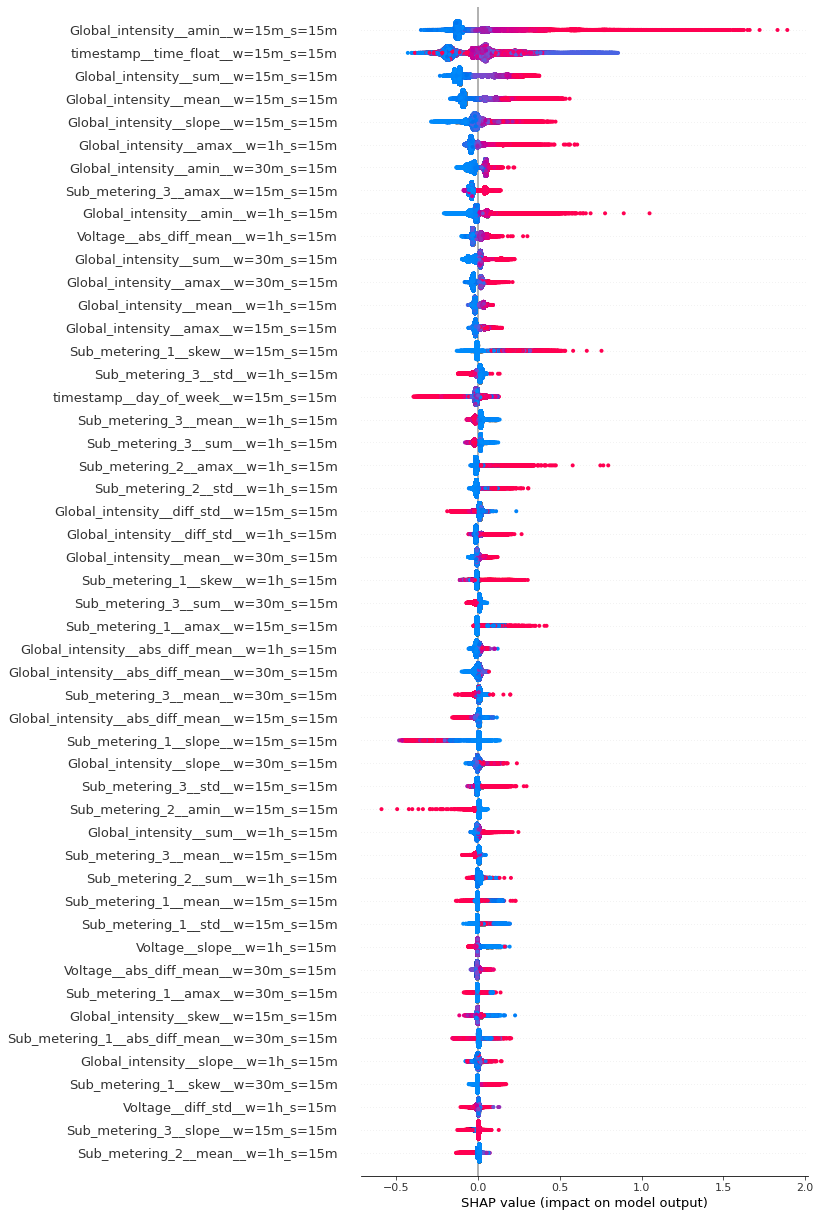

In [156]:
plt.figure()
explainer = shap.TreeExplainer(pipe)
shap_values = explainer.shap_values(df_train_feats[selected_cols])
shap.summary_plot(shap_values, df_train_feats[selected_cols], max_display=50, 
                    auto_size_plot=True, show=False, color_bar=False)
plt.show()

In [157]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(selected_cols, vals)),columns=['col_name','feature_importance_vals'])
feature_importance = feature_importance.sort_values(by=['feature_importance_vals'],ascending=False).reset_index(drop=True)
feature_importance.head()

,col_name,feature_importance_vals
0,Global_intensity__amin__w=15m_s=15m,0.146
1,timestamp__time_float__w=15m_s=15m,0.131
2,Global_intensity__sum__w=15m_s=15m,0.126
3,Global_intensity__mean__w=15m_s=15m,0.098
4,Global_intensity__slope__w=15m_s=15m,0.053


In [158]:
n = 50
important_cols = feature_importance[:n]['col_name'].values

In [159]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline

In [160]:
df_train_feats.shape

(110060, 155)

In [161]:
gmm_pipe = Pipeline([
    ('scaler', PowerTransformer()),
    ('gmm', GaussianMixture(n_components=25, covariance_type='diag', random_state=42)),
])

In [ ]:
gmm_pipe.fit(df_train_feats[important_cols].dropna(how='any'))

In [ ]:
# loglh = gmm_pipe.score_samples(df_test_feats[important_cols].dropna(how='any'))
# loglh = pd.Series(index=df_test_feats[important_cols].dropna(how='any').index, data=loglh)

# AE = (df_test_tot['predictions'] - df_test_tot[y_test.name]).abs()

# from scipy.stats import pearsonr

# joined = AE.rename('MAE').to_frame().join((loglh * -1).rename('loglh')).dropna(how='any')
# pearsonr(joined.MAE, joined.loglh)

## Uncertainty

In [162]:
pipe_upper = catboost.CatBoostRegressor(verbose=100, loss_function='Quantile:alpha=0.975')
pipe_lower = catboost.CatBoostRegressor(verbose=100, loss_function='Quantile:alpha=0.025')

# as this is a lot of data, this might take a minute or 5
pipe_upper.fit(df_train[selected_cols], df_train[y_train.name])
pipe_lower.fit(df_train[selected_cols], df_train[y_train.name])

0:	learn: 0.0850670	total: 65.2ms	remaining: 1m 5s
100:	learn: 0.0514491	total: 3.07s	remaining: 27.3s
200:	learn: 0.0484751	total: 6.74s	remaining: 26.8s
300:	learn: 0.0474380	total: 9.87s	remaining: 22.9s
400:	learn: 0.0469063	total: 12.9s	remaining: 19.3s
500:	learn: 0.0464889	total: 15.7s	remaining: 15.6s
600:	learn: 0.0458493	total: 18.6s	remaining: 12.3s
700:	learn: 0.0454763	total: 21.4s	remaining: 9.15s
800:	learn: 0.0454136	total: 24.2s	remaining: 6.01s
900:	learn: 0.0453446	total: 26.9s	remaining: 2.96s
999:	learn: 0.0452942	total: 29.7s	remaining: 0us
0:	learn: 0.0244079	total: 57.8ms	remaining: 57.8s
100:	learn: 0.0216338	total: 3.53s	remaining: 31.4s
200:	learn: 0.0201003	total: 6.83s	remaining: 27.2s
300:	learn: 0.0196026	total: 9.98s	remaining: 23.2s
400:	learn: 0.0191437	total: 13.2s	remaining: 19.8s
500:	learn: 0.0189165	total: 16.3s	remaining: 16.2s
600:	learn: 0.0188273	total: 19s	remaining: 12.6s
700:	learn: 0.0188050	total: 21.6s	remaining: 9.23s
800:	learn: 0.0187

In [163]:
def PICP(y_true,y_lower,y_upper):
    return np.logical_and(y_lower<=y_true, y_true<=y_upper).sum()/len(y_true)*100
    
def NMPIW(y_true,y_lower,y_upper):
    return np.mean(y_upper-y_lower)/(np.max(y_true)-np.min(y_true))
    
def MPIW(y_true,y_lower,y_upper):
    return np.mean(y_upper-y_lower)

#def pred_Crossing(y_pred,y_lower,y_upper):
#    return np.logical_or(y_upper<y_pred,y_pred<y_lower).sum()/len(y_true)*100

#def quantile_Crossing(y_lower,y_upper):
#    return (y_upper<y_lower).sum()/len(y_true)*100

In [164]:
train_predictions_upper = pipe_upper.predict(df_train_feats_[selected_cols])
train_predictions_lower = pipe_lower.predict(df_train_feats_[selected_cols])

nan_mask = df_train_feats_[y_train.name].notna()
y_true, y_pred_upper, y_pred_lower = df_train_feats_[y_train.name][nan_mask], train_predictions_upper[nan_mask], train_predictions_lower[nan_mask]

print("[TEST] PICP = "+str(np.round(PICP(y_true.values,y_pred_lower,y_pred_upper),2))+" % -- NMPIW = "+str(np.round(NMPIW(y_true.values,y_pred_lower,y_pred_upper),2))+" -- MPIW = "+str(np.round(MPIW(y_true.values,y_pred_lower,y_pred_upper),2))+" kW")

[TEST] PICP = 95.0 % -- NMPIW = 0.24 -- MPIW = 2.0 kW


In [165]:
out_upper = pipe_upper.predict(df_test_tot[selected_cols])
out_lower = pipe_lower.predict(df_test_tot[selected_cols])

df_test_tot["predictions_upper"] = out_upper
df_test_tot["predictions_lower"] = out_lower

nan_mask = df_test_tot[y_test.name].notna()
y_true, y_pred_upper, y_pred_lower = df_test_tot[nan_mask][y_test.name], df_test_tot[nan_mask]["predictions_upper"], df_test_tot[nan_mask]["predictions_lower"]

print("[TEST] PICP = "+str(np.round(PICP(y_true.values,y_pred_lower.values,y_pred_upper.values),2))+" % -- NMPIW = "+str(np.round(NMPIW(y_true.values,y_pred_lower.values,y_pred_upper.values),2))+" -- MPIW = "+str(np.round(MPIW(y_true.values,y_pred_lower.values,y_pred_upper.values),2))+" kW")

[TEST] PICP = 95.29 % -- NMPIW = 0.25 -- MPIW = 1.92 kW


## Visualizing predictions

In [166]:
import plotly.graph_objects as go

fig = FigureResampler(make_subplots(rows=2, shared_xaxes=True, specs=[[{}], [{'secondary_y': True}]]), default_n_shown_samples=1000)

fig.add_trace(
    go.Scattergl(name='target'),
    hf_x=y_test.index, hf_y=y_test, row=1, col=1
)

fig.add_trace(
    go.Scattergl(name="predictions", marker_color="red"),
    hf_x=df_test_tot.index, hf_y=df_test_tot.predictions, row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_test_tot.index,
        y=df_test_tot.predictions_upper,
        name="upper_bound",
        showlegend=False,
        marker_color='black',
        line=dict(width=0),
        mode='lines',
    ),
)

fig.add_trace(
    go.Scatter(
        x=df_test_tot.index,
        y=df_test_tot.predictions_lower,
        name="lower bound",
        showlegend=False,
        marker_color='black',
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(255, 0, 0, 0.2)',
        fill='tonexty'
    ),
)
    
#fig.add_trace(
#    go.Scattergl(name=f"GAP_shift{shift_min}min", visible='legendonly'),
#    hf_x=df_test.index, hf_y=df_test['Global_active_power'].shift(shift_min),
#    row=2, col=1
#)

# fig.add_trace(
#     go.Scattergl(name=f"MAE"), hf_x=AE.index, hf_y=AE, row=2, col=1
# )

# fig.add_trace(
#     go.Scattergl(name='neg-loglh'),
#     hf_x=loglh.index, hf_y=loglh * -1, secondary_y=True, row=2, col=1
# )



# also visualize the lower and upper bounds; 
#   these values are the predictions +/- std, respectively

# fig.add_trace(
#     go.Scatter(
#         x=df_test_tot.index[:size],
#         y=df_test_tot.predictions[:size] + df_test_tot["std"][:size],
#         name="upper_bound",
#         showlegend=False,
#         marker_color='black',
#         line=dict(width=0),
#         mode='lines',
#     ),
# )

# fig.add_trace(
#     go.Scatter(
#         x=df_test_tot.index[:size],
#         y=df_test_tot.predictions[:size] - df_test_tot["std"][:size],
#         name="lower bound",
#         showlegend=False,
#         marker_color='black',
#         line=dict(width=0),
#         mode='lines',
#         fillcolor='rgba(255, 0, 0, 0.2)',
#         fill='tonexty'
#     ),
# )


fig.update_layout(title="Power consumption predictions", title_x=0.5, hovermode='x')
fig.update_xaxes(title="Time")
fig.update_yaxes(title="AVG power consumption (kW)")
# fig.update_layout(height=600)
fig.show_dash(mode='external', height=700)

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.


Dash app running on http://127.0.0.1:8050/


# Next step -> going to production

In [94]:
fc.serialize('fc.pkl')